## Import Libraries


In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import gc, sys


## Data Analysis


In [30]:
raw_data = pd.read_csv("/kaggle/input/tips-dataset/tips.csv")
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")
raw_data.head()

There are 244 observations in the dataset.
There are 11 variables in the dataset.


,total_bill,tip,sex,smoker,day,time,size,price_per_person,Payer Name,CC Number,Payment ID
0,16.99,1.01,Female,No,Sun,Dinner,2,8.49,Christy Cunningham,3560325168603410,Sun2959
1,10.34,1.66,Male,No,Sun,Dinner,3,3.45,Douglas Tucker,4478071379779230,Sun4608
2,21.01,3.50,Male,No,Sun,Dinner,3,7.00,Travis Walters,6011812112971322,Sun4458
3,23.68,3.31,Male,No,Sun,Dinner,2,11.84,Nathaniel Harris,4676137647685994,Sun5260
4,24.59,3.61,Female,No,Sun,Dinner,4,6.15,Tonya Carter,4832732618637221,Sun2251


## Data Cleaning


There are 242 observations in the dataset.
There are 9 variables in the dataset.


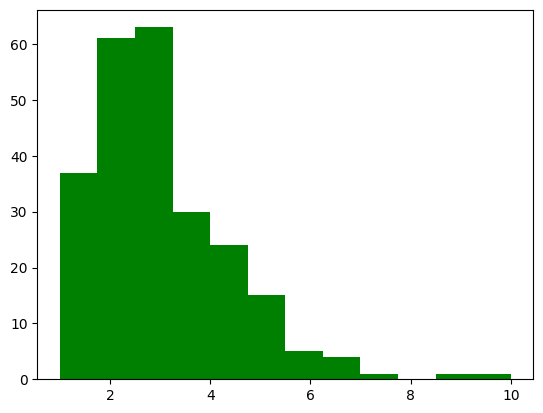

Minimum amount value is  1.0
Maximum amount value is  10.0
90% of the meals have a tip amount less or equal than  5.0


In [31]:
# We wanna check for any outliers, maybe a tip that is more than 40% of the total bill
clean_data = raw_data[raw_data['tip']<raw_data['total_bill']*0.4]
# remove all rows that shows the tip being more than 40* of the total bill, removing potential outliers
clean_data = clean_data.drop(["CC Number", "Payment ID"], axis = 1)
# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip.values, 12, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip.values))
print("Maximum amount value is ", np.max(clean_data.tip.values))
print("90% of the meals have a tip amount less or equal than ", np.percentile(clean_data.tip.values, 90))

In [13]:
clean_data.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person,Payer Name,CC Number,Payment ID
0,16.99,1.01,Female,No,Sun,Dinner,2,8.49,Christy Cunningham,3560325168603410,Sun2959
1,10.34,1.66,Male,No,Sun,Dinner,3,3.45,Douglas Tucker,4478071379779230,Sun4608
2,21.01,3.50,Male,No,Sun,Dinner,3,7.00,Travis Walters,6011812112971322,Sun4458
3,23.68,3.31,Male,No,Sun,Dinner,2,11.84,Nathaniel Harris,4676137647685994,Sun5260
4,24.59,3.61,Female,No,Sun,Dinner,4,6.15,Tonya Carter,4832732618637221,Sun2251


## Dataset Preprocessing


In [36]:
#Estiamte the bill cost for the tip payer based on the total bill and size
clean_data["Tip Payer Bill"] = np.ceil(clean_data['total_bill']/ clean_data['size'])
#Calculate the percentage of the tip to the amount spent on the tip payer
clean_data['Tip Percentage'] = np.ceil(clean_data['tip'] / clean_data['Tip Payer Bill'] * 100)
clean_data.head


<bound method NDFrame.head of      total_bill   tip     sex smoker   day    time  size  price_per_person  \
0         16.99  1.01  Female     No   Sun  Dinner     2              8.49   
1         10.34  1.66    Male     No   Sun  Dinner     3              3.45   
2         21.01  3.50    Male     No   Sun  Dinner     3              7.00   
3         23.68  3.31    Male     No   Sun  Dinner     2             11.84   
4         24.59  3.61  Female     No   Sun  Dinner     4              6.15   
..          ...   ...     ...    ...   ...     ...   ...               ...   
239       29.03  5.92    Male     No   Sat  Dinner     3              9.68   
240       27.18  2.00  Female    Yes   Sat  Dinner     2             13.59   
241       22.67  2.00    Male    Yes   Sat  Dinner     2             11.34   
242       17.82  1.75    Male     No   Sat  Dinner     2              8.91   
243       18.78  3.00  Female     No  Thur  Dinner     2              9.39   

             Payer Name  Tip Paye

In [37]:
# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
clean_data = clean_data.drop("Payer Name", axis = 1)
get_dummy_col = ["sex","smoker","day","time"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

del clean_data
gc.collect()

# extract the labels from the dataframe
y = proc_data[['tip']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (242, 15) y.shape= (242, 1)


## Dataset Train/Test Split



In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)



X_train.shape= (169, 15) Y_train.shape= (169, 1)
X_test.shape= (73, 15) Y_test.shape= (73, 1)


## Build a Decision Tree Regressor Model with Scikit-Learn

In [39]:
# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  0.00490


In [42]:
# import the Decision Tree Regressor Model from Snap ML
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training 
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  0.02684


## Evaluating the Scikit-Learn and SnapML Decision Tree Regression Models

In [43]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 0.18x 
[Scikit-Learn] MSE score : 0.414
[Snap ML] MSE score : 0.591
